'''
!pip install matplotlib
!pip install numpy
!pip install --upgrade pyspark
!pip install findspark
'''

Init (follow:https://python.plainenglish.io/apache-spark-using-jupyter-in-linux-installation-and-setup-b2cacc6c7701 to set up)

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

spark = SparkSession.builder.getOrCreate()

df = spark.read.option("header", True).option("inferSchema", "true").csv("modis_2000-2019_Australia.csv")
df.printSchema()
df.show()

root
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- brightness: double (nullable = true)
 |-- scan: double (nullable = true)
 |-- track: double (nullable = true)
 |-- acq_date: string (nullable = true)
 |-- acq_time: integer (nullable = true)
 |-- satellite: string (nullable = true)
 |-- instrument: string (nullable = true)
 |-- confidence: integer (nullable = true)
 |-- version: double (nullable = true)
 |-- bright_t31: double (nullable = true)
 |-- frp: double (nullable = true)
 |-- daynight: string (nullable = true)
 |-- type: integer (nullable = true)

+--------+---------+----------+----+-----+----------+--------+---------+----------+----------+-------+----------+-----+--------+----+
|latitude|longitude|brightness|scan|track|  acq_date|acq_time|satellite|instrument|confidence|version|bright_t31|  frp|daynight|type|
+--------+---------+----------+----+-----+----------+--------+---------+----------+----------+-------+----------+-----+--------+--

Logic for sending images

In [3]:
import base64
import io
import requests
import json

def getBase64(location):
    pic_IObytes = None
    if location:
        with open(location, 'rb') as fh:
            pic_IObytes = io.BytesIO(fh.read())
    else:
        pic_IObytes = io.BytesIO()
        plt.savefig(pic_IObytes,  format='png')

    pic_IObytes.seek(0)
    return base64.b64encode(pic_IObytes.read())

def sendImage(filename, description, location = None):
    base = getBase64(location)
    
    payload = {
        str(filename): {
            "desc": str(description),
            "image": "data:image/png;base64," + base.decode("utf-8")
        }
    }

    requests.patch('https://dataintproj-default-rtdb.firebaseio.com/database/blobs.json', json.dumps(payload))

Number of fires each year:

+----+------+
|year| count|
+----+------+
|2000| 30724|
|2001|235315|
|2002|335342|
|2003|212359|
|2004|312386|
|2005|190139|
|2006|304651|
|2007|254931|
|2008|183518|
|2009|251914|
|2010|120558|
|2011|437141|
|2012|474964|
|2013|190517|
|2014|256921|
|2015|239462|
|2016|159223|
|2017|273312|
|2018|307359|
|2019|310484|
+----+------+



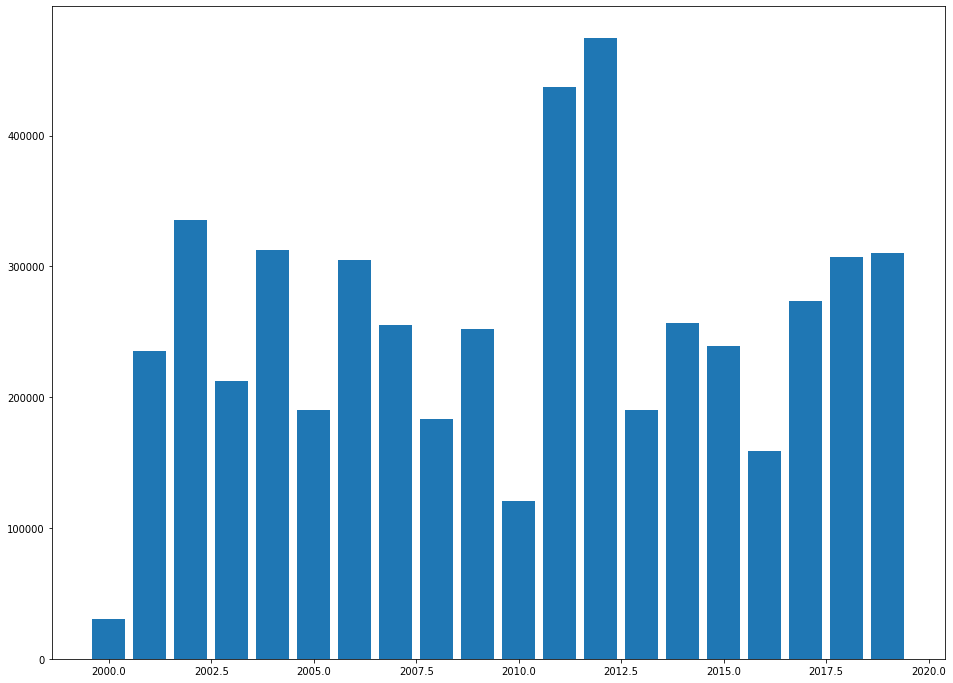

In [40]:
years_df = df.groupBy(year(col("acq_date")).alias("year")).count().orderBy(asc("year"))
years_df.show()

years = years_df.toPandas()

figure(figsize=(16, 12))
plt.bar(years['year'], years['count'])

sendImage("Fires each year", "Number of fires heppening each year (2000-2019)")

Total fires:

In [42]:
total_count = df.count()
print(total_count)

5081220


Percent of fires each month:

+-----+------+
|month| count|
+-----+------+
|    1|225722|
|    2|104742|
|    3|113271|
|    4|312055|
|    5|405533|
|    6|289521|
|    7|308731|
|    8|457470|
|    9|693241|
|   10|896729|
|   11|802695|
|   12|471510|
+-----+------+



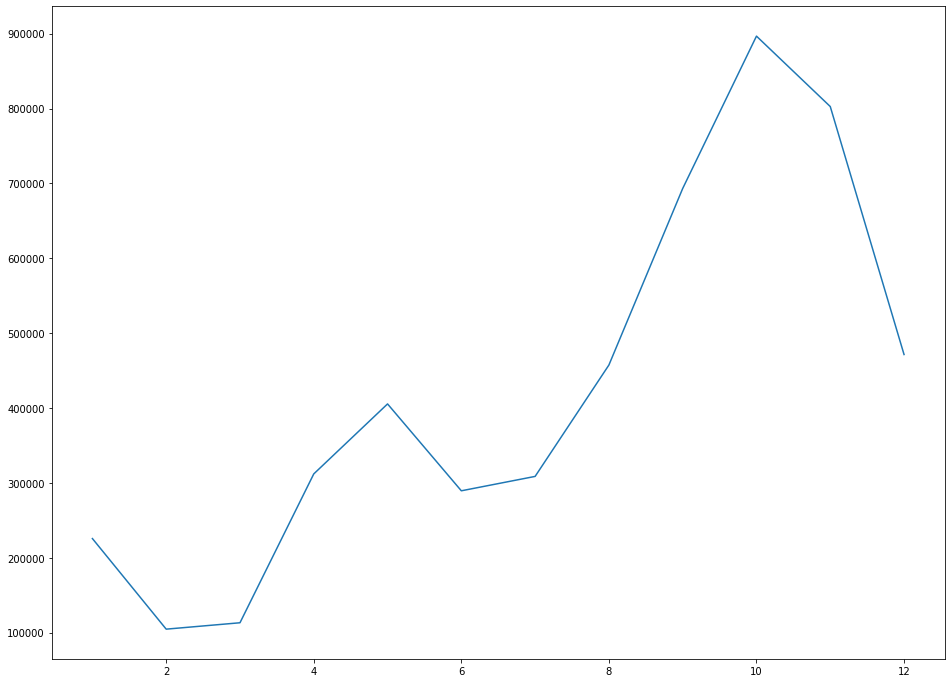

In [43]:
months_df = df.groupBy(month(col("acq_date")).alias("month")).count().orderBy(asc("month"))
months_df.show()

months = months_df.toPandas()

figure(figsize=(16, 12))
plt.plot(months['month'],months['count'])

sendImage("Fires each month", "Number of fires heppening each month (2000-2019)")

time at which fires occur:

(time recored as 2359, with last 2 digits identifying minutes)

+--------+-------+
|acq_hour|  count|
+--------+-------+
|     0.0| 383327|
|     1.0| 859595|
|     2.0| 349227|
|     3.0| 349070|
|     4.0|1075517|
|     5.0| 745787|
|     6.0| 122325|
|     7.0|    515|
|    11.0|   1131|
|    12.0| 160602|
|    13.0| 326561|
|    14.0| 253939|
|    15.0| 143256|
|    16.0| 178158|
|    17.0|  85530|
|    18.0|   1958|
|    23.0|  44722|
+--------+-------+



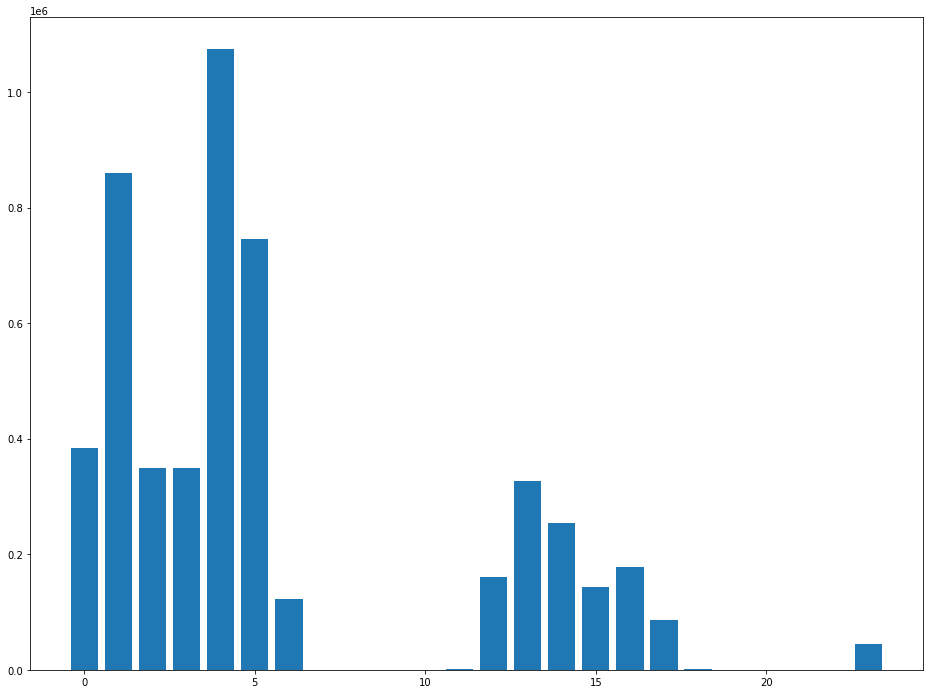

In [44]:
hours_df = df.withColumn("acq_hour",(col("acq_time")-col("acq_time")%100)/100).groupBy(col("acq_hour")).count().orderBy(asc("acq_hour"))
hours_df.show()

hours = hours_df.toPandas()

figure(figsize=(16, 12))
plt.bar(hours['acq_hour'],hours['count'])

sendImage("Fires each hour", "Number of fires heppening each hour (2000-2019)")

number of fire occurances in a certain regions, ordered by count. Region consits of 1 degree of latitude and longitude. The entry is placed in to the specific region by rounding down to int values.

In [48]:
import gmaps
from pyspark.sql.types import FloatType

location_precision = 0.1

aprox_location_df = df.withColumn("aprox_latitude",col("latitude")-col("latitude")%location_precision).withColumn("aprox_longitude",col("longitude")-col("longitude")%location_precision).select(col("aprox_latitude"), col("aprox_longitude")).groupBy("aprox_latitude","aprox_longitude").count()
aprox_location_df.orderBy(desc("count")).show()

gmaps.configure(api_key='xxx')

figure_layout = {
'width': '800px',
'height': '700px',
'border': '1px solid black',
'padding': '1px'
}
fig = gmaps.figure(layout=figure_layout)

locations = aprox_location_df.select(col("aprox_latitude"), col("aprox_longitude")).toPandas()
weights = aprox_location_df.select(col("count").cast(FloatType())).toPandas()['count']

heatmap_layer = gmaps.heatmap_layer(locations, weights=weights)
fig.add_layer(heatmap_layer)
fig

+-------------------+------------------+-----+
|     aprox_latitude|   aprox_longitude|count|
+-------------------+------------------+-----+
|              -34.4|             150.8| 7228|
|-20.700000000000003|             139.4| 5149|
|              -30.8|             121.4| 4886|
|-11.700000000000001|             130.9| 1501|
|-12.600000000000001|             142.0| 1359|
|              -12.4|             141.8| 1319|
|-11.600000000000001|130.70000000000002| 1312|
|-11.600000000000001|             130.9| 1310|
|-11.700000000000001|             130.8| 1295|
|              -12.9|             141.6| 1263|
|              -11.5|131.20000000000002| 1252|
|-11.600000000000001|             131.0| 1247|
|-11.600000000000001|             130.6| 1226|
|              -11.4|             130.8| 1157|
|-12.100000000000001|             133.5| 1145|
|-11.600000000000001|131.20000000000002| 1122|
|              -14.3|129.70000000000002| 1120|
|-11.700000000000001|             130.1| 1102|
|-14.10000000

Figure(layout=FigureLayout(border='1px solid black', height='700px', padding='1px', width='800px'))

Use this code to upload the generated google image (you need to download it):

In [55]:
#download folder location and the file name might change if downloaded multiple times or run on differen machine
sendImage("Fires heat map", "Heatmap of fires that have happened in australia (2000-2019)", "/home/bubrik/Downloads/map.png")

average location of all fire (just to understand if fires are skewed to certain point in the country)

In [56]:
df.select(avg(col("latitude")), avg(col("longitude"))).show()

+-------------------+------------------+
|      avg(latitude)|    avg(longitude)|
+-------------------+------------------+
|-20.601503684449415|134.72413741465883|
+-------------------+------------------+



What was the lovest/highest brightness value and their respective counts.

Brightness temperature 21 (Kelvin): Channel 21/22 brightness temperature of the fire pixel measured in Kelvin.

0 K = -273.15 °C

In [61]:
temperaure_precision = 1
kelvin_to_celsius = -273

celsius_df = df.select((col("brightness") -col("brightness")%temperaure_precision + kelvin_to_celsius).alias("Temperature Celsius")).groupBy(col("Temperature Celsius")).count()

print("hottest fire: ", celsius_df.orderBy(desc("Temperature Celsius")).first())

hottest fire:  Row(Temperature Celsius=234.0, count=1)


Confidence (0-100%)

In [29]:
#shows how confidence cooralates to brightness
df.groupBy(col("confidence")).avg("brightness").orderBy(asc("confidence")).show(100)

#filter out values with low confidence
df.filter(col("confidence") >= 20).show()

+----------+------------------+
|confidence|   avg(brightness)|
+----------+------------------+
|         0|330.15512310504215|
|         1|303.11809523809524|
|         2|        303.199375|
|         3| 303.8575603557814|
|         4|304.99115456238366|
|         5|305.48121098626746|
|         6| 305.7919958953311|
|         7|306.44654731457814|
|         8| 307.3270692717586|
|         9| 307.8313253012048|
|        10|308.63926728586205|
|        11| 309.1758783783785|
|        12|309.94821081291315|
|        13|310.36559120723274|
|        14| 311.1781111111109|
|        15|311.81996099735323|
|        16|312.34543007306735|
|        17| 313.0145369831095|
|        18| 313.3817069243154|
|        19|313.70774832507993|
|        20|314.25650329061256|
|        21|314.67933815581586|
|        22| 315.2229043864345|
|        23|315.58651383287383|
|        24|315.99340018351114|
|        25| 316.2689462021432|
|        26| 316.6722428465362|
|        27| 316.9224359661344|
|       

Predict using mllib

links: https://spark.apache.org/docs/latest/ml-pipeline.html https://spark.apache.org/docs/latest/ml-classification-regression.html#regression https://www.lucasallen.io/spark-dataframes-mllib-tutorial/ https://spark.apache.org/docs/1.4.1/ml-features.html

+----------+----+-----+---+-----+-----------------+------------------+
|      date|year|month|day|label|         features|        prediction|
+----------+----+-----+---+-----+-----------------+------------------+
|2018-01-01|2018|    1|  1|  286| [2018.0,1.0,1.0]|207.40935399767355|
|2018-01-02|2018|    1|  2|  399| [2018.0,1.0,2.0]|206.78532472630758|
|2018-01-03|2018|    1|  3|  406| [2018.0,1.0,3.0]| 206.1612954549416|
|2018-01-04|2018|    1|  4|  504| [2018.0,1.0,4.0]|205.53726618357567|
|2018-01-05|2018|    1|  5|  551| [2018.0,1.0,5.0]| 204.9132369122097|
|2018-01-06|2018|    1|  6|  429| [2018.0,1.0,6.0]|204.28920764084373|
|2018-01-07|2018|    1|  7|  270| [2018.0,1.0,7.0]|203.66517836947776|
|2018-01-08|2018|    1|  8|  221| [2018.0,1.0,8.0]| 203.0411490981118|
|2018-01-09|2018|    1|  9|  310| [2018.0,1.0,9.0]|202.41711982674582|
|2018-01-10|2018|    1| 10|  385|[2018.0,1.0,10.0]|201.79309055537985|
|2018-01-11|2018|    1| 11|  422|[2018.0,1.0,11.0]| 201.1690612840139|
|2018-

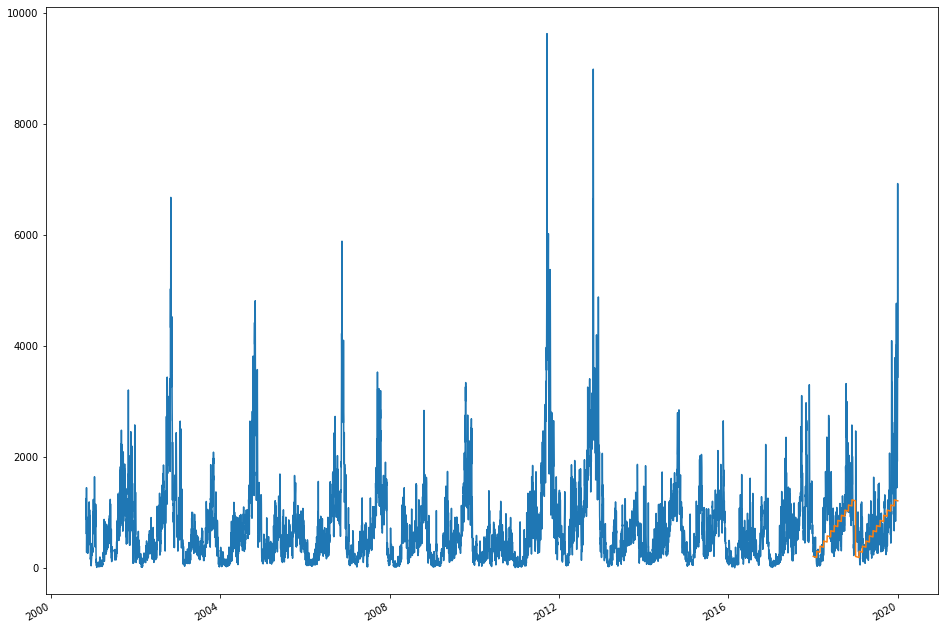

In [4]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression

prediction_df = df.groupBy(col("acq_date")).count().select(
    to_date(col("acq_date"), "yyyy-MM-dd").alias("date"),
    year(col("acq_date")).alias("year"),
    month(col("acq_date")).alias("month"),
    dayofmonth(col("acq_date")).alias("day"),
    col("count").alias("label")).orderBy(col("date"))
#prediction_df.show()

assembler = VectorAssembler(
  inputCols=["year", "month", "day"], outputCol="features"
)
assembled_df = assembler.transform(prediction_df)
#assembled_df.show()

#Prepare training data.
training_df = assembled_df.filter(col("year") < 2018)
#Prepare test data.
test_df = assembled_df.filter(col("year") >= 2018)

lr = LinearRegression()

# Fit the model
lrModel = lr.fit(training_df)

# Predict
results = lrModel.transform(test_df)
results.show()

# Plot results

figure(figsize=(16, 12))
dates = assembled_df.select(col("date")).toPandas()
data = assembled_df.select(col("label")).toPandas()

plt.plot(dates, data)

dates = results.select(col("date")).toPandas()
data = results.select(col("prediction")).toPandas()

plt.plot(dates, data)

# If you don't like the break in the graph, change 90 to 89 in the above line
plt.gcf().autofmt_xdate()

sendImage("Count of fires", "Number of fires each day (orange line indicates the predicted values for years 2018-19)")